# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Normalize data and create embeddings for each time point fraction

In [2]:
timepoint <- "T4"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#here::dr_here(show_reason = TRUE)
source(here::here("SCGRES_119_120/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here::here(glue::glue("{qc}/{robj_dir}/clean_combined_object_{timepoint}.rds")))

In [6]:
head(seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample_org,timepoint,replicate,sample_id,pct_mt,percent.ribo,doublet_score,doublet_pred
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
T4_1_AAACCTGAGCTAGTTC-1,SCGRES_119_120,3933,1744,OS0043_1,T4,1,T4_1,1.881515,18.5354691,0.03658537,FALSE
T4_1_AAACCTGAGCTTTGGT-1,SCGRES_119_120,2447,1134,OS0043_1,T4,1,T4_1,2.983245,8.3367389,0.18765432,FALSE
T4_1_AAACCTGAGTACGCGA-1,SCGRES_119_120,5419,2424,OS0043_1,T4,1,T4_1,5.462262,11.1644215,0.04806530,FALSE
T4_1_AAACCTGAGTGCTGCC-1,SCGRES_119_120,2036,1102,OS0043_1,T4,1,T4_1,3.438114,25.1964637,0.05404967,FALSE
T4_1_AAACCTGCAAACTGCT-1,SCGRES_119_120,4106,197,OS0043_1,T4,1,T4_1,0.000000,0.1704822,0.04485412,FALSE
T4_1_AAACCTGCAAATCCGT-1,SCGRES_119_120,12845,3890,OS0043_1,T4,1,T4_1,1.899572,14.8462437,0.05669844,FALSE


## Normalization and linear dimensional reduction

In [7]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [8]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 28061 27909 
metadata(0):
assays(2): counts logcounts
rownames(28061): AL627309.1 AL627309.3 ... AC141272.1 AC007325.2
rowData names(0):
colnames(27909): T4_1_AAACCTGAGCTAGTTC-1 T4_1_AAACCTGAGCTTTGGT-1 ...
  T4_2_TTTGTCATCTATCCTA-1 T4_2_TTTGTCATCTTTACAC-1
colData names(12): orig.ident nCount_RNA ... doublet_pred ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


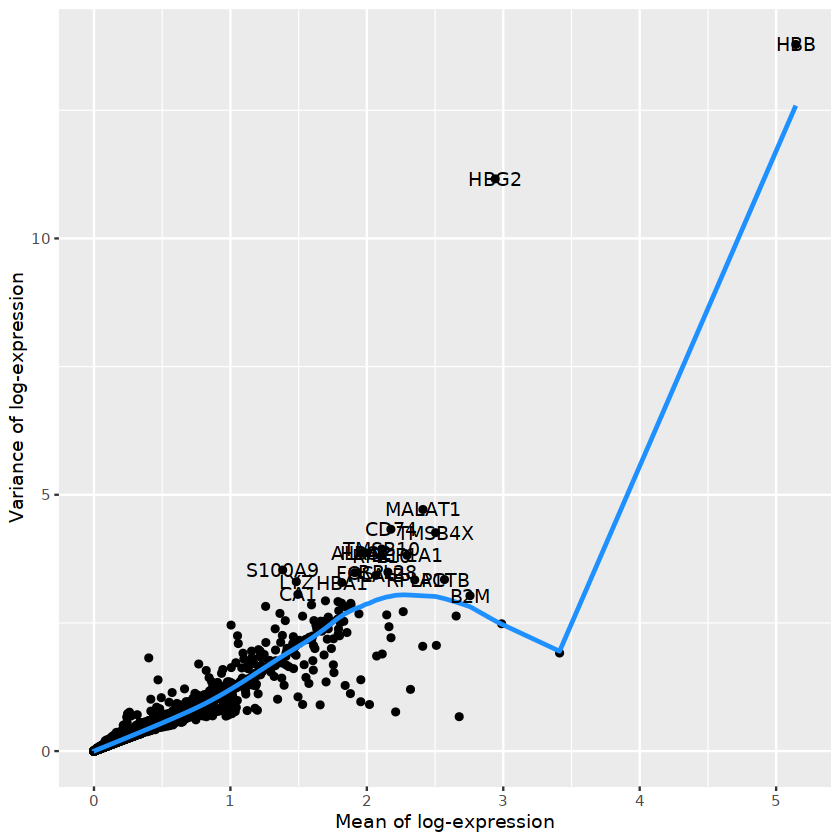

In [9]:
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [10]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

,mean,total,tech,bio,p.value,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HBB,5.144020,13.783549,12.590538,1.1930104,2.593897e-01,8.758959e-01
HBG2,2.941094,11.161632,2.539100,8.6225314,1.319244e-118,7.321012e-115
MALAT1,2.411243,4.712934,3.028574,1.6843599,7.619923e-05,3.809550e-03
CD74,2.176178,4.326257,3.020234,1.3060232,1.616953e-03,4.919473e-02
TMSB4X,2.503620,4.260423,3.015575,1.2448480,2.469455e-03,6.859480e-02
TMSB10,2.109346,3.940604,2.977598,0.9630065,1.382205e-02,2.480727e-01
HBA2,1.991081,3.870100,2.862471,1.0076292,8.264346e-03,1.735888e-01
ALAS2,1.956012,3.858496,2.816181,1.0423147,5.862796e-03,1.345534e-01
EEF1A1,2.294700,3.819505,3.045216,0.7742891,4.168987e-02,5.205980e-01


In [11]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.1)
length(hvgs)

[1] 1100

In [12]:
hvgs

[1] "HBG2"          "MALAT1"        "S100A9"        "GNLY"         
   [5] "CD74"          "LYZ"           "S100A8"        "TMSB4X"       
   [9] "HBD"           "CA1"           "HBG1"          "NKG7"         
  [13] "IFI30"         "HBM"           "CST3"          "VCAN"         
  [17] "CCL5"          "PFN1"          "IFITM1"        "IFI27"        
  [21] "PRF1"          "IFIT1B"        "FCN1"          "JUN"          
  [25] "GZMB"          "IL32"          "GZMA"          "CTSW"         
  [29] "PPBP"          "FCGR3A"        "HLA-DQA1"      "CXCL8"        
  [33] "IL1B"          "CD7"           "CD247"         "CST7"         
  [37] "CD14"          "S100A12"       "CCL3"          "PRKCH"        
  [41] "IL2RB"         "CD69"          "SKAP1"         "TUBB1"        
  [45] "PF4"           "CFD"           "PITHD1"        "CYP1B1"       
  [49] "STRADB"        "C1QA"          "CCL4"          "THBS1"        
  [53] "KIF5C"         "IL2RG"         "LMNA"          "KLRB1"        
  [57] "SYNE2"         "APOBEC3A"      "TMCC2"         "CD3E"         
  [61] "GZMH"          "GZMK"          "LTB"           "C1QB"         
  [65] "SYNE1"         "GP9"           "GNG11"         "KLRD1"        
  [69] "KLRK1"         "SLC38A1"       "ZAP70"         "HOPX"         
  [73] "CAVIN2"        "KLRC1"         "FGFBP2"        "CLIC3"        
  [77] "CD96"          "SPON2"         "GZMM"          "SAMD3"        
  [81] "G0S2"          "ITGA2B"        "MCTP2"         "ADGRG1"       
  [85] "CDK6"          "CD3D"          "MPIG6B"        "HIST1H2AC"    
  [89] "KLF12"         "THEM5"         "LCK"           "KLF1"         
  [93] "ACRBP"         "PYHIN1"        "NCAM1"         "SERPINB2"     
  [97] "TRBC1"         "AFF3"          "PCED1B-AS1"    "TGFBR3"       
 [101] "LIME1"         "NCALD"         "STMN1"         "KLRF1"        
 [105] "GRAP2"         "SMOX"          "MYL9"          "PTCRA"        
 [109] "ETS1"          "LAT"           "RAP1GAP"       "TXK"          
 [113] "TOX"           "CLU"           "SPARC"         "TRBC2"        
 [117] "TSC22D1"       "STAT4"         "RHOH"          "CARD11"       
 [121] "TMEM40"        "CMTM5"         "AUTS2"         "NKAIN2"       
 [125] "KCNQ5"         "ABLIM1"        "RORA"          "TUBB2A"       
 [129] "XCL2"          "HIST1H1D"      "RAB27B"        "INPP4B"       
 [133] "CD1C"          "C1QC"          "IKZF3"         "ARG1"         
 [137] "BEX3"          "KLRC2"         "TREML1"        "ITGB3"        
 [141] "RHAG"          "SOX6"          "JCHAIN"        "ALOX5AP"      
 [145] "XCL1"          "CD27"          "NCR3"          "KIR3DL1"      
 [149] "ITLN1"         "TC2N"          "FCMR"          "LINC01934"    
 [153] "SPOCK2"        "HIST1H1B"      "CD2"           "ITK"          
 [157] "C2orf88"       "SLFN12L"       "MKI67"         "TRDC"         
 [161] "IKZF2"         "ITM2A"         "SH2D1B"        "LILRA4"       
 [165] "BCL2"          "CD9"           "RRM2"          "LINC00299"    
 [169] "BACH2"         "GP1BA"         "C19orf33"      "EREG"         
 [173] "CASC15"        "BCL11B"        "PRSS57"        "SPTA1"        
 [177] "SH2D2A"        "KLRG1"         "HIST1H3H"      "AL589693.1"   
 [181] "LTBP1"         "CD3G"          "RGS6"          "MZB1"         
 [185] "CD8A"          "IL18RAP"       "PDZK1IP1"      "STON2"        
 [189] "TRBV20-1"      "PF4V1"         "SH2D1A"        "PPP2R2B"      
 [193] "CD5"           "AL136456.1"    "DNM3"          "LY6G6F"       
 [197] "GFI1B"         "FCER1A"        "LEF1"          "MMD"          
 [201] "TIGIT"         "CLEC1B"        "FAM30A"        "LINC02772"    
 [205] "MMRN1"         "IGKC"          "MYLK"          "CHI3L2"       
 [209] "SH3BGRL2"      "HIST1H2BJ"     "LINC01505"     "S1PR5"        
 [213] "MEIS1"         "CTTN"          "PBX1"          "SERPINF1"     
 [217] "ITM2C"         "AJ009632.2"    "CENPF"         "THEMIS"       
 [221] "ALOX12"        "KIR2DL4"       "ICOS"          "SPINK2"       
 [225] "IL7R"          "IFN

In [13]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

# remove BCR genes
hvgs <- hvgs[!grepl("^IG[HKL]V", hvgs)]
hvgs <- hvgs[!grepl("^IG[HKL]J", hvgs)]
hvgs <- hvgs[!grepl("^IG[KL]C", hvgs)]
hvgs <- hvgs[!grepl("^IGH[ADEGM]", hvgs)]
length(hvgs)

[1] 963

In [14]:
list_objects = SplitObject(seurat_obj,  split.by = "sample_id")

In [15]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  PRF1, GZMA, CD247, CTSW, NKG7, CD7, CST7, GNLY, SKAP1, PRKCH 
	   GZMB, ZAP70, IL2RB, KLRK1, IL32, SAMD3, IL2RG, KLRD1, SYNE2, CD96 
	   IFITM1, GZMM, KLRB1, GZMH, SYNE1, HOPX, KLRC1, SLC38A1, CD69, LCK 
Negative:  CA1, HBD, HBG2, HBG1, IFIT1B, HBM, LYZ, FCN1, S100A9, IFI30 
	   VCAN, S100A8, IFI27, CD14, STRADB, CST3, IL1B, S100A12, CXCL8, CYP1B1 
	   CFD, KLF1, APOBEC3A, RAP1GAP, PITHD1, TMCC2, HLA-DQA1, SMOX, THEM5, ITLN1 
PC_ 2 
Positive:  GP9, TUBB1, MPIG6B, GNG11, CAVIN2, PF4, ITGA2B, PPBP, ACRBP, CMTM5 
	   TMEM40, PTCRA, SPARC, ITGB3, TREML1, CLU, BEX3, GP1BA, MYL9, TSC22D1 
	   GRAP2, HIST1H2AC, C19orf33, LY6G6F, MYLK, RAB27B, CLEC1B, ALOX12, SH3BGRL2, CTTN 
Negative:  CA1, HBG2, HBG1, IFIT1B, HBD, HBM, STRADB, IFI27, PITHD1, RAP1GAP 
	   KLF1, ARG1, ITLN1, TUBB2A, SOX6, PRF1, GZMA, CD247, IL2RB, FAM83A 
	   ZAP70, GZMM, GNLY, GZMH, KLRD1, KLRK1, CD7, GZMB, SFRP2, SAMD3 
PC_ 3 
Positive:  IFI30, LYZ, CD74, FCN1, S100A9, CST3

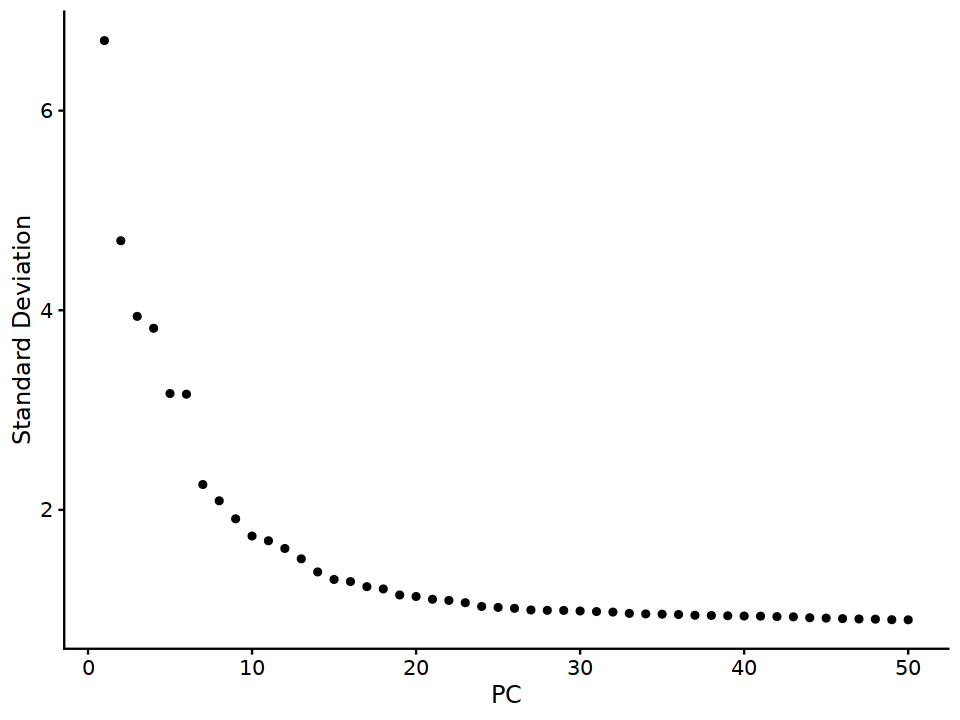

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [17]:
ProjectDim(seurat_obj, reduction = "pca")

PC_ 1 
Positive:  PRF1, GZMA, CD247, CTSW, NKG7, CD7, CST7, GNLY, SKAP1, PRKCH 
	   GZMB, ZAP70, IL2RB, KLRK1, IL32, SAMD3, IL2RG, KLRD1, SYNE2, CD96 
Negative:  CA1, HBD, HBG2, HBG1, IFIT1B, HBM, LYZ, FCN1, S100A9, IFI30 
	   VCAN, S100A8, IFI27, CD14, STRADB, CST3, IL1B, S100A12, CXCL8, CYP1B1 
PC_ 2 
Positive:  GP9, TUBB1, MPIG6B, GNG11, CAVIN2, PF4, ITGA2B, PPBP, ACRBP, CMTM5 
	   TMEM40, PTCRA, SPARC, ITGB3, TREML1, CLU, BEX3, GP1BA, MYL9, TSC22D1 
Negative:  CA1, HBG2, HBG1, IFIT1B, HBD, HBM, STRADB, IFI27, PITHD1, RAP1GAP 
	   KLF1, ARG1, ITLN1, TUBB2A, SOX6, PRF1, GZMA, CD247, IL2RB, FAM83A 
PC_ 3 
Positive:  IFI30, LYZ, CD74, FCN1, S100A9, CST3, TMSB4X, VCAN, S100A8, MALAT1 
	   CD14, JUN, PFN1, IL1B, CXCL8, HLA-DQA1, S100A12, CYP1B1, CFD, CCL3 
Negative:  CA1, HBG2, HBD, HBG1, IFIT1B, HBM, STRADB, IFI27, KLF1, TMCC2 
	   PITHD1, RAP1GAP, SMOX, RHAG, THEM5, ARG1, ITLN1, PBX1, TUBB2A, SOX6 
PC_ 4 
Positive:  CCL5, TUBB1, PPBP, GP9, PF4, MPIG6B, GRAP2, CMTM5, TREML1, ITGA2B 
	  

An object of class Seurat 
28061 features across 27909 samples within 1 assay 
Active assay: RNA (28061 features, 0 variable features)
 1 dimensional reduction calculated: pca

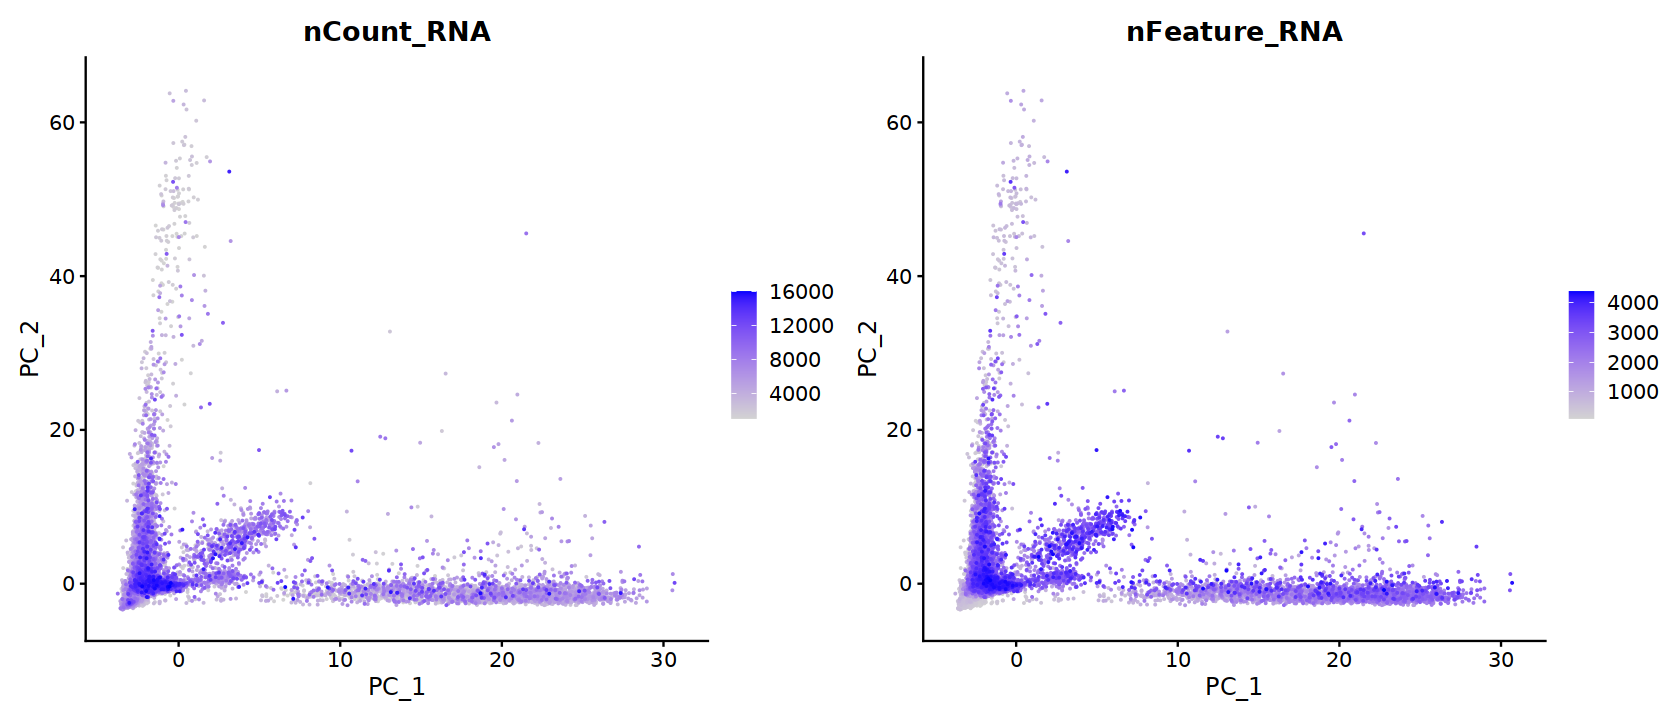

In [18]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

## UMAP representation

In [19]:
comp=15

In [20]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:08:04 UMAP embedding parameters a = 0.9922 b = 1.112

13:08:04 Read 27909 rows and found 15 numeric columns

13:08:04 Using Annoy for neighbor search, n_neighbors = 30

13:08:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:08:08 Writing NN index file to temp file /scratch_tmp/33937378/RtmppB929t/file2be2078e80df7

13:08:08 Searching Annoy index using 1 thread, search_k = 3000

13:08:20 Annoy recall = 100%

13:08:21 Commencing smooth kNN distance calibration using 1 thread
 with t

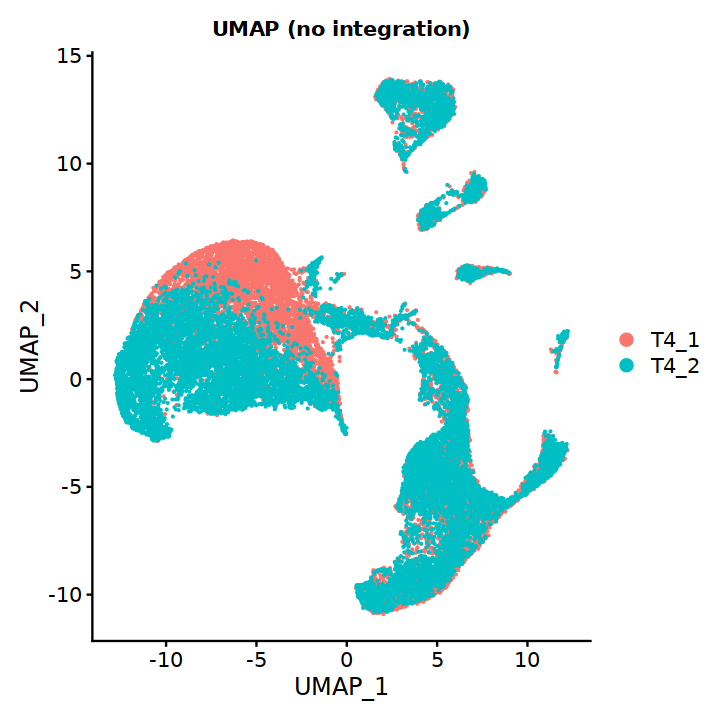

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

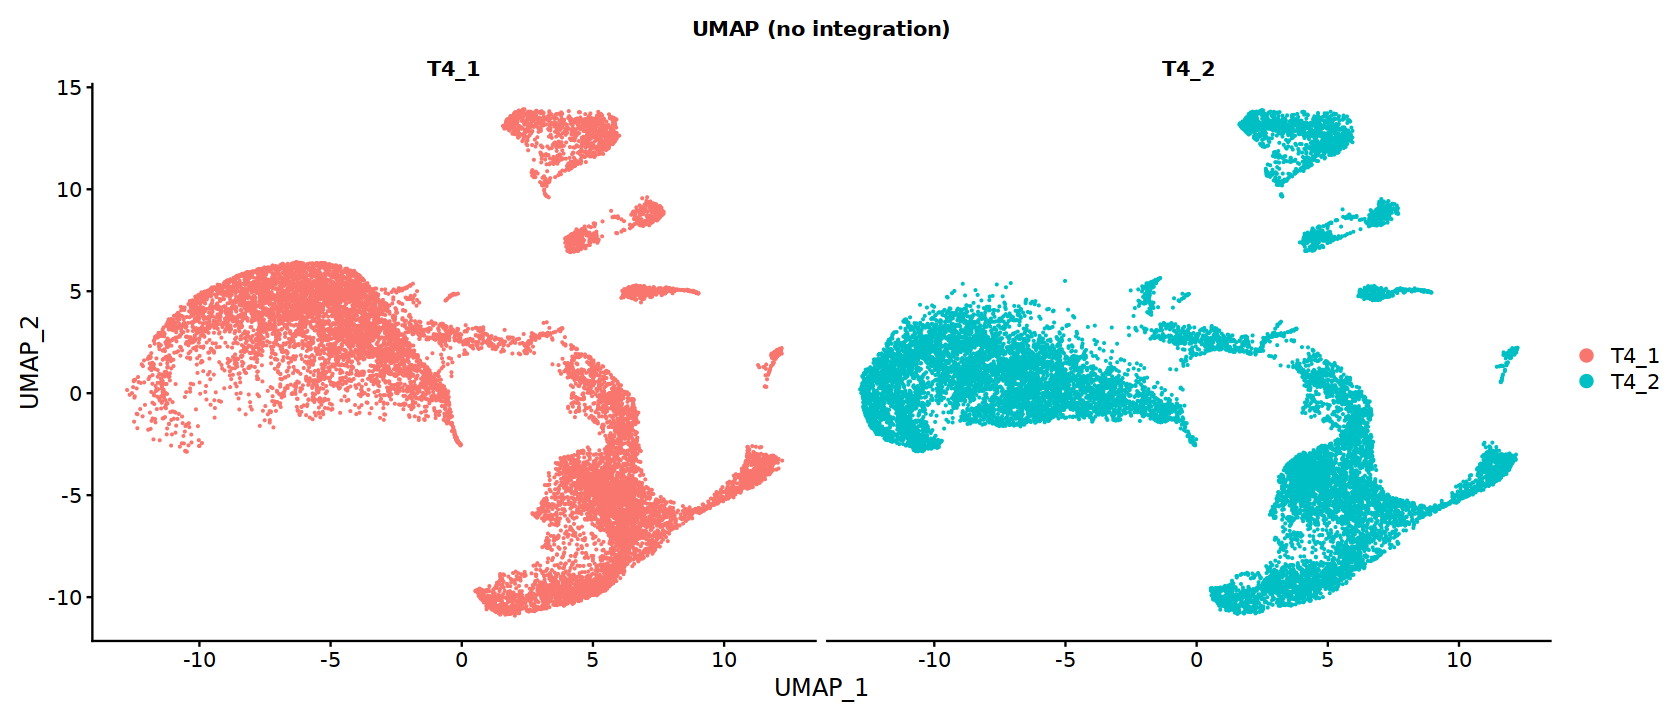

In [22]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Integration with Harmony

In [23]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [24]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



In [25]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

13:09:40 UMAP embedding parameters a = 0.9922 b = 1.112

13:09:40 Read 27909 rows and found 15 numeric columns

13:09:40 Using Annoy for neighbor search, n_neighbors = 30

13:09:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:09:43 Writing NN index file to temp file /scratch_tmp/33937378/RtmppB929t/file2be203fac737d

13:09:43 Searching Annoy index using 1 thread, search_k = 3000

13:09:55 Annoy recall = 100%

13:09:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:09:57 Initializing from normalized Laplacian + noise (using irlba)

13:09:58 Commencing optimization for 200 epochs, with 1195150 positive edges

13:10:29 Optimization finished



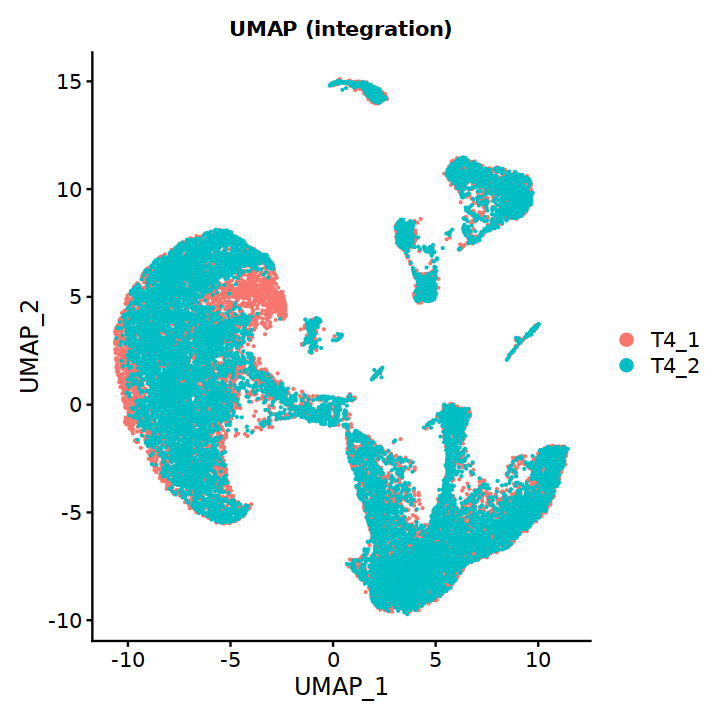

In [26]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

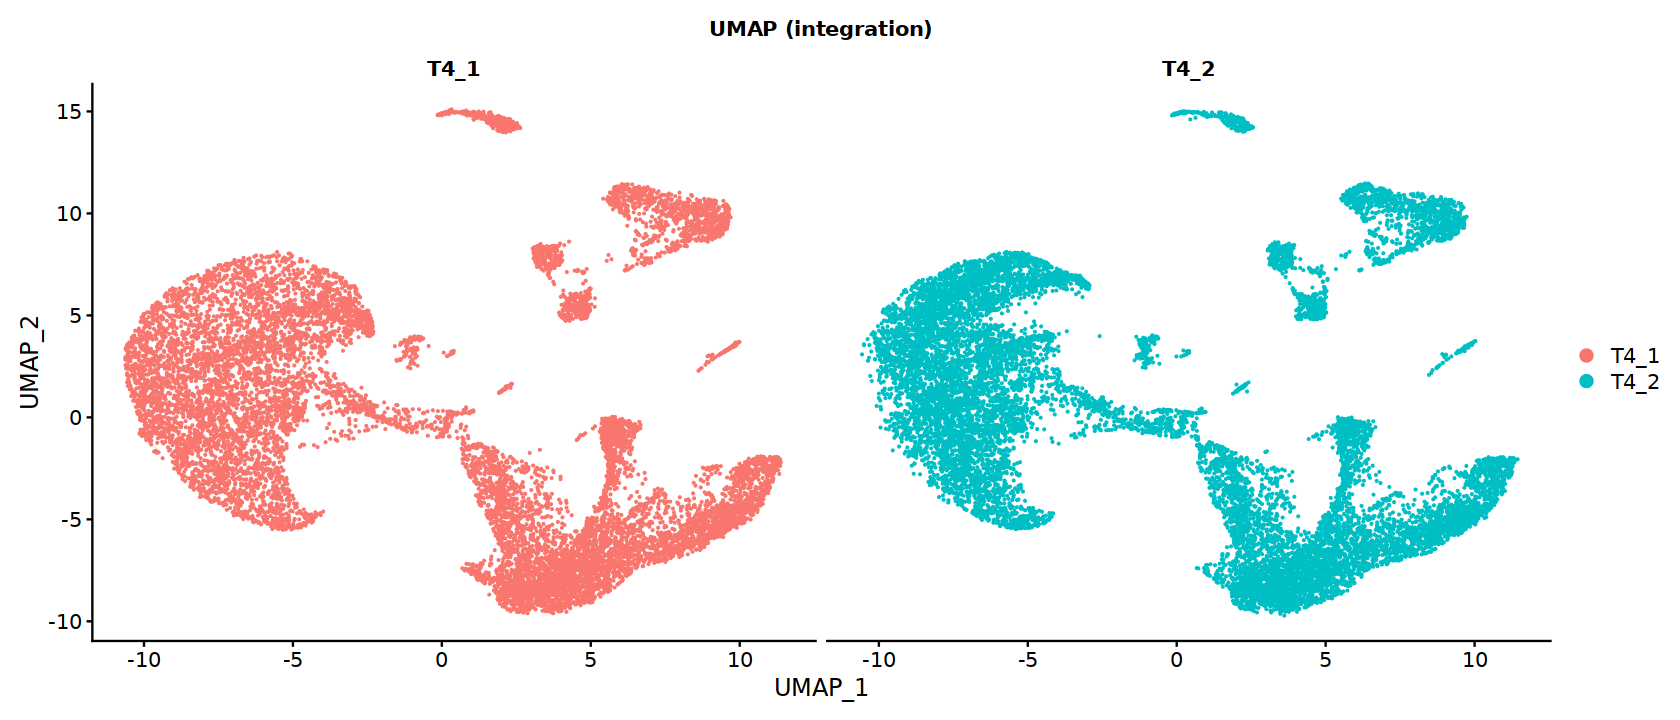

In [27]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [28]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [29]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "HBM")
vars <- c(cat_vars, con_vars)

In [30]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

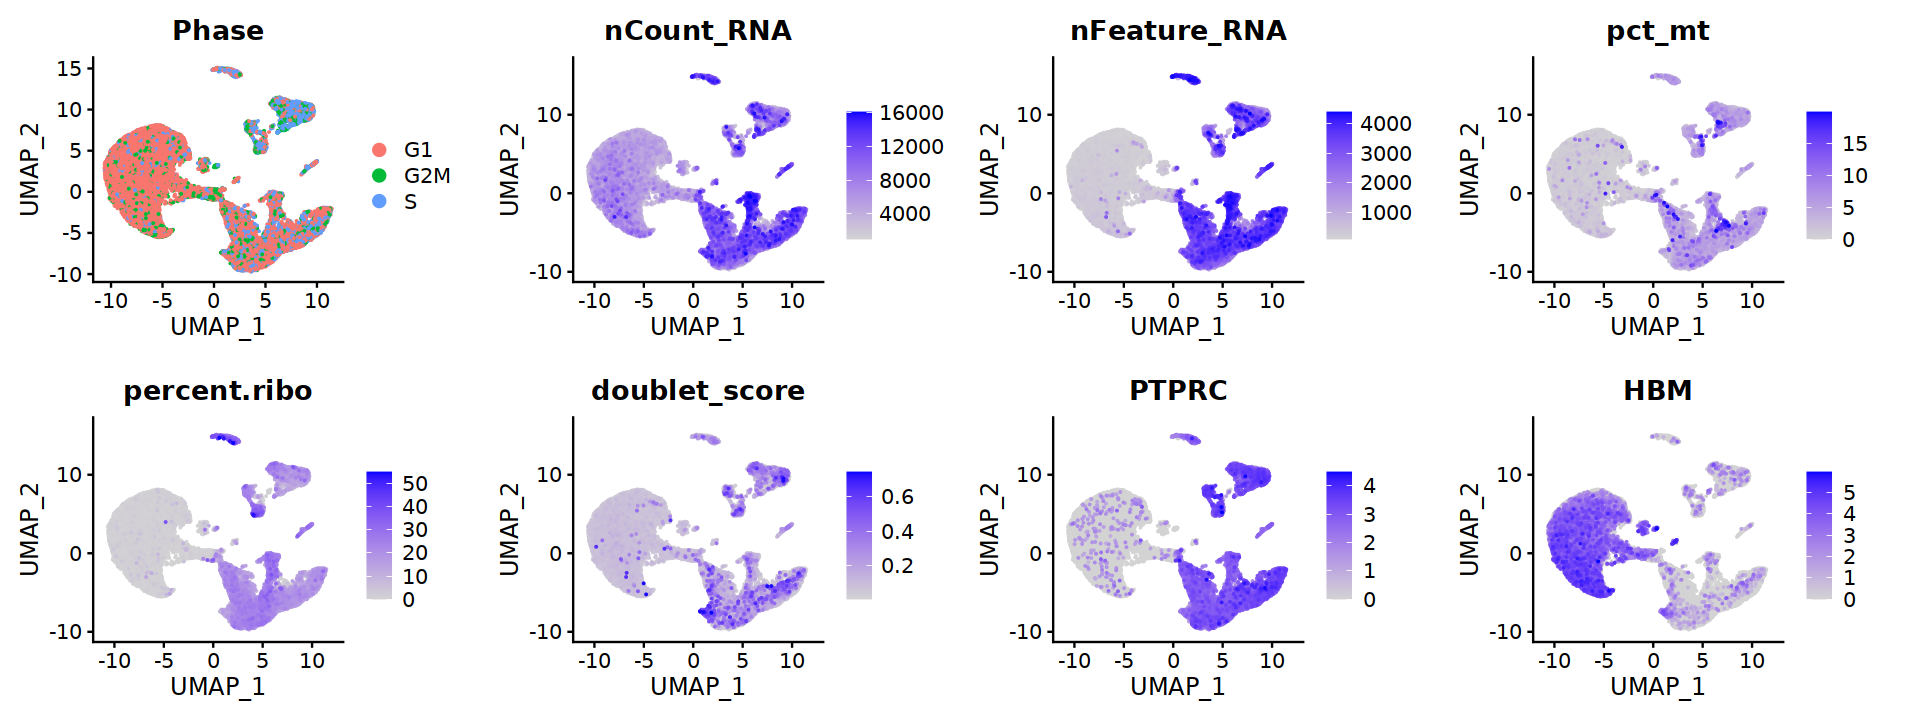

In [31]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)
cp

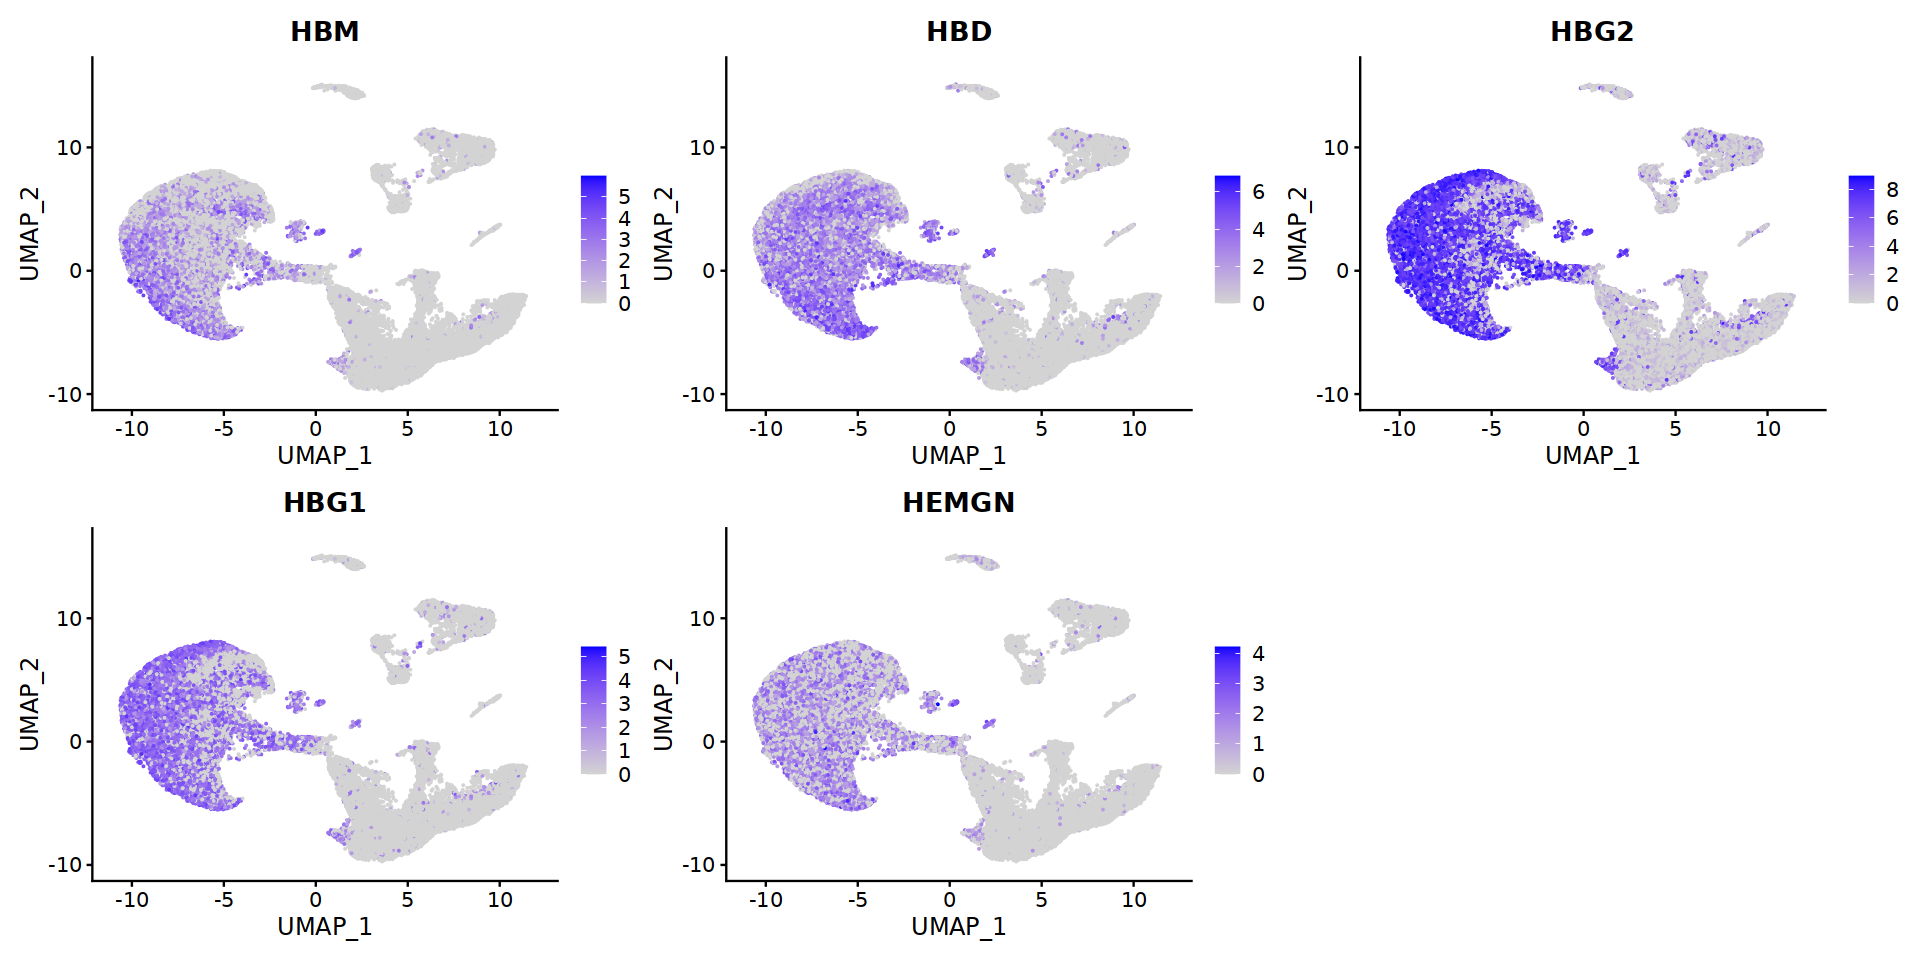

In [32]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
hemo_genes = c("HBM", "HBD", "HBG2","HBG1", "HEMGN")

FeaturePlot(seurat_obj, reduction = "umap", feature=hemo_genes, order = FALSE, ncol=3)

Erythrocytes need to be removed

# Save

In [33]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

# Session Info

In [34]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_